In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [15]:
#os.chdir('C://Users//adam//Desktop//dagger')

In [29]:
#import, clean and format HI data
hdi_file = 'data/Human Development Index (HDI).csv'
hdi_df = pd.read_csv(hdi_file, encoding = "ISO-8859-1", skiprows=1)
columns = ["Country"]

for i in range(1990, 2018):
   columns = columns + [str(i)]

hdi_df = hdi_df[columns]
hdi_df = hdi_df.melt(id_vars='Country', var_name='Year', value_name="HDI")
hdi_df = hdi_df.dropna()
hdi_df['Country'] = hdi_df['Country'].str.strip()
#hdi_df.head()

In [30]:
#import and clean the power data
power_file = 'data/global_power_plant_database.csv'
power_df = pd.read_csv(power_file)
power_df['commissioning_year'] = round(power_df['commissioning_year'],0)
power_df = power_df[power_df['commissioning_year']>=1990]
#power_df.head()

In [31]:
#importing, cleaning, and formatting the population data
pop_file = ('data/API_SP.POP.TOTL_DS2_en_csv_v2_103676.csv')
pop_df = pd.read_csv(pop_file, encoding = "ISO-8859-1", skiprows=4)
pop_df = pop_df.drop(['Country Code', 'Indicator Name', 'Indicator Code'], axis=1)
pop_df = pop_df.melt(id_vars='Country Name', var_name='Year', value_name='Population')
pop_df = pop_df.rename(columns={'Country Name':'Country'})
#pop_df.head()

In [32]:
#filter power df and create df for cumulative capacity
pow_pd = power_df[['country_long', 'capacity_mw', 'commissioning_year' ]]
pow_pd.head(20)
country_list = pow_pd['country_long'].unique()

cap_data = pd.DataFrame(columns = ['country_long', 'commissioning_year'])

for i in range(len(country_list)):
    for year in range(1990, 2018):
        cap_data.loc[i*37 + year-1990] = [country_list[i], year]    

# Aggregate capacity when same country and year
countries = pow_pd.groupby(['country_long', 'commissioning_year'])
cap_added = countries['capacity_mw'].sum()

In [33]:
# merge data agreggate capacity with counrty year df
cap_cont_yr = pd.merge(cap_data, cap_added, on=['country_long', 'commissioning_year'], how='left')
cap_cont_yr = cap_cont_yr.fillna(0)

In [34]:
# create cumulative cap by country and year
cap_cont_yr['commissioning_year'] = cap_cont_yr['commissioning_year'].astype(str)
cap_cum = cap_cont_yr.groupby(by=['country_long', 'commissioning_year']).sum().groupby(level=[0]).cumsum()

In [35]:
# merge hdi, pop, and capacity by Country and Year
hdi_pop_merged = pd.merge(hdi_df, pop_df, on=['Country', 'Year'])
merged_data = pd.merge(hdi_pop_merged, cap_cum, left_on=['Country', 'Year'], right_on=['country_long', 'commissioning_year'])

In [88]:
# Capacity is based on added capacity beginning using end of 1989 as baseline.  Does not include losses in capacity.

merged_data.head()
# merged_data[merged_data['Country']=='China']
    

,Country,Year,HDI,Population,capacity_mw
0,Algeria,1990,0.577,25758869.0,0.00
1,Argentina,1990,0.704,32618651.0,761.02
2,Armenia,1990,0.631,3538171.0,0.00
3,Austria,1990,0.795,7677850.0,13.00
4,Bahrain,1990,0.746,495931.0,0.00


Country of interest: China


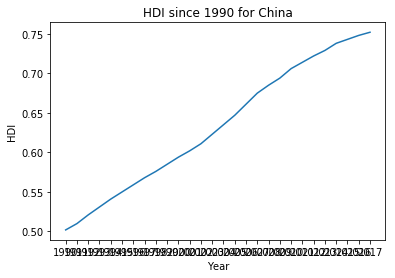

In [82]:
country = input("Country of interest: ")
country_df = merged_data[merged_data['Country']==country]

plt.plot(country_df['Year'], country_df['HDI'])

plt.title(f"HDI since 1990 for {country}")
plt.xlabel("Year")
plt.ylabel("HDI")
plt.show()

Country of interest: China


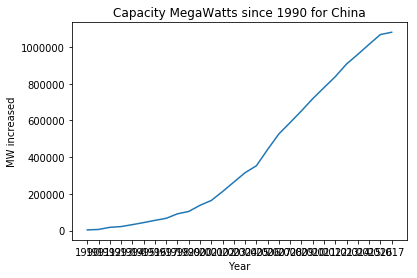

In [83]:
country = input("Country of interest: ")
country_df = merged_data[merged_data['Country']==country]

plt.plot(country_df['Year'], country_df['capacity_mw'])

plt.title(f"Capacity MegaWatts since 1990 for {country}")
plt.xlabel("Year")
plt.ylabel("MW increased")
plt.show()

In [52]:
merged_data['HDI'].corr(merged_data['capacity_mw'])

0.01896294672060638

In [53]:
merged_data['Population'].corr(merged_data['capacity_mw'])

0.6651227892089613

In [54]:
country_df = merged_data[merged_data['Country']=='Japan']
country_df['Population'].corr(country_df['capacity_mw'])

0.9281685266987779

In [55]:
country_df['HDI'].corr(country_df['capacity_mw'])

0.9487733933503127

In [85]:
corr_data = pd.DataFrame(columns=['Country', 'HDI-cap corr', 'Pop-cap corr', 'HDI-pop corr'])


In [58]:
country_df.corr()

,HDI,Population,capacity_mw
HDI,1.000000,0.800259,0.948773
Population,0.800259,1.000000,0.928169
capacity_mw,0.948773,0.928169,1.000000


In [72]:
for i in range(len(country_list)):
    country = country_list[i]
    country_df = merged_data[merged_data['Country']==country]
    hdi_cap = country_df['HDI'].corr(country_df['capacity_mw'])
    pop_cap = country_df['Population'].corr(country_df['capacity_mw'])
    hdi_pop = country_df['HDI'].corr(country_df['Population'])
    corr_data.loc[i] = [country, hdi_cap, pop_cap, hdi_pop]
    
#corr_data.head(10)    

,Country,HDI-cap corr,Pop-cap corr,HDI-pop corr
0,Algeria,0.793523,0.887917,0.975498
1,Argentina,0.978499,0.954034,0.984750
2,Armenia,0.733899,-0.533111,-0.842938
3,Austria,0.934973,0.913569,0.960277
4,Azerbaijan,0.961797,0.986072,0.967129
5,Bahrain,0.858753,0.954888,0.859946
6,Bangladesh,0.950889,0.928154,0.993824
7,Belgium,0.913122,0.956956,0.880580
8,Brazil,0.955413,0.957865,0.993275
9,Bulgaria,0.801707,-0.737936,-0.984143


In [74]:
corr_data.sort_values('HDI-cap corr', ascending=False)

,Country,HDI-cap corr,Pop-cap corr,HDI-pop corr
28,Guatemala,0.985012,0.989647,0.994095
77,Thailand,0.983231,0.976523,0.995176
11,Canada,0.978744,0.982330,0.990429
1,Argentina,0.978499,0.954034,0.984750
32,India,0.977178,0.956980,0.994723
57,Pakistan,0.974407,0.979382,0.993875
12,China,0.969198,0.919628,0.985548
51,Morocco,0.968194,0.974993,0.994616
25,Germany,0.967009,0.324107,0.332717
61,Philippines,0.962993,0.961368,0.997725
